# Get Odds and Convert to Win Probability

In [10]:
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

data_DIR = "../data/rapm/"
misc_DIR = "../data/misc/"
model_path = "../data/models/"
pbp_DIR = "../data/pbpdata/"
fig_DIR = "../figs/analysis/"

# %matplotlib widget

## Scrape from Rotowire

In [11]:
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

url = "https://www.rotowire.com/betting/nba/tables/games-archive.php"
response = requests.get(url,headers=header)
odds_js = response.json()
odds = pd.DataFrame(odds_js)
odds.to_parquet(misc_DIR + "NBA_odds.parquet")

## Load Box

In [12]:
seasons = np.arange(2017,2024)
box = get_box("T","Base",False,seasons)
box = box.loc[box["matchup"].str.contains(" vs. ")]
# box["matchup"] = box["matchup"].str.replace(" ","")
box["matchup"] = box["matchup"].str.split(" vs. ",expand=True)[1]
box = box.rename(columns={"team_abbreviation":"home_team_abbrev", "matchup":"visit_team_abbrev","team_id":"tidh"})
box["win"] = np.where(box["wl"] == "W",1,0)
box = box[["game_id","tidh","home_team_abbrev","visit_team_abbrev","game_date","win"]]

## Load Odds

In [13]:
odds = pd.read_parquet(misc_DIR + f"NBA_odds.parquet")
odds["game_date"] = pd.to_datetime(odds["game_date"])
odds["season"] = odds["season"].astype(int)
odds["net"] = odds["home_team_score"] - odds["visit_team_score"]
odds["win"] = np.where(odds["net"]>0,1,0)
odds = odds.query("season < 2024")

In [14]:
oddl = odds.groupby("line")[["win"]].agg({"win":["sum","count"]})
oddl = oddl.reset_index()
oddl.columns = ["line","wins","tot"]
oddl["win_pct"] = oddl["wins"]/oddl["tot"]
oddl["win_pct"] = oddl["win_pct"].round(3)
oddl = oddl.rename(columns={"line":"spread"})

## Find Fit

In [15]:
slope, intercept, r, p, sterr = scipy.stats.linregress(x=oddl["spread"], y=oddl["win_pct"])
r2 = r**2
print(r2)
slope = round(slope,4)
intercept = round(intercept,4)
print(slope)
print(intercept)

0.9276429968922458
-0.0262
0.4952


## Plot Fit

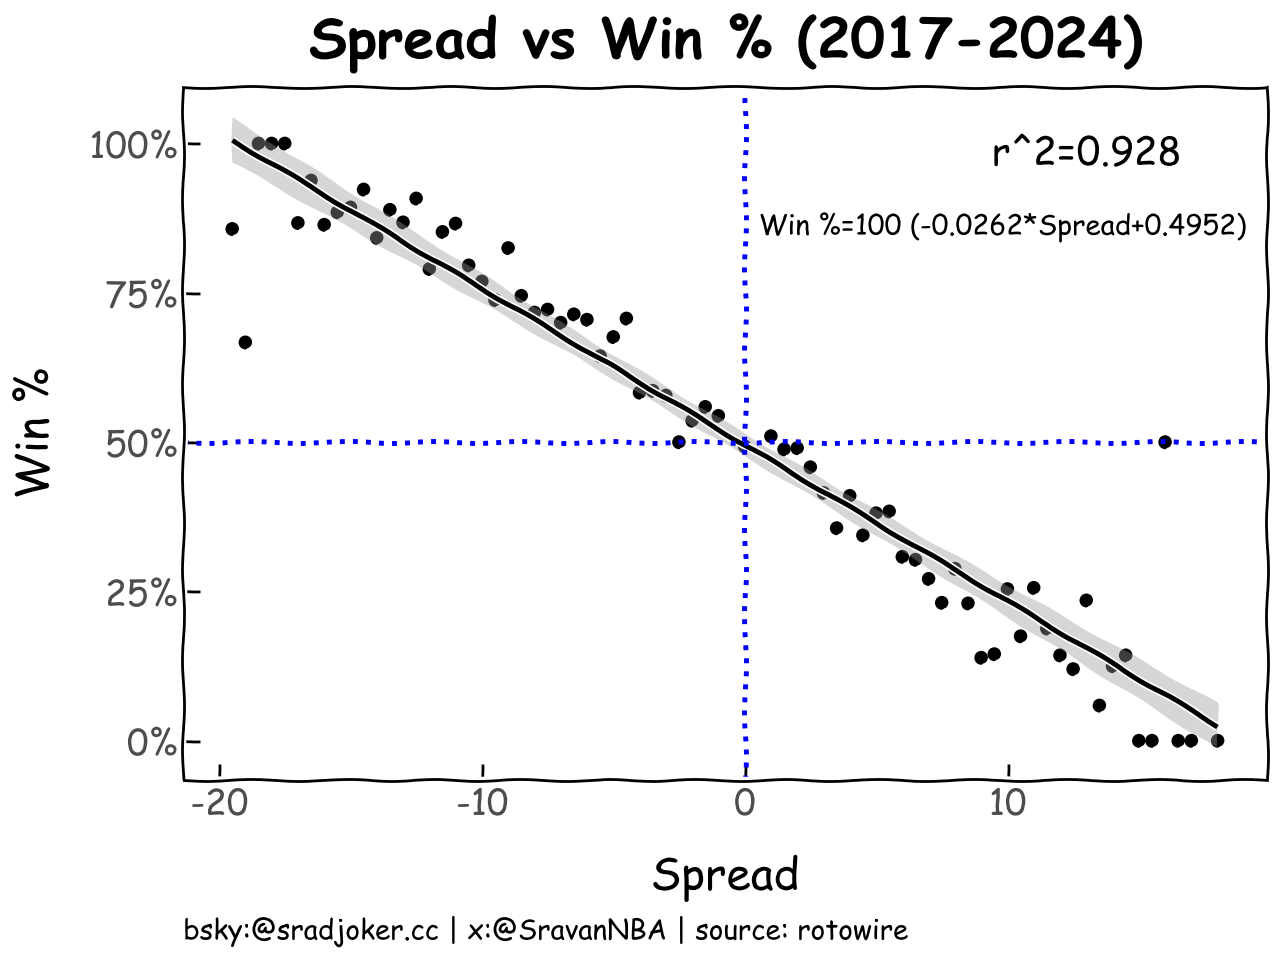

In [16]:
p = (
    ggplot(oddl)
    + aes(x="spread",y="win_pct")
    + geom_point()
    + geom_smooth(method="lm")
    + geom_vline(xintercept=0,color="blue",linetype="dotted",size=1)
    + geom_hline(yintercept=0.5,color="blue",linetype="dotted",size=1)
    + scale_y_continuous(labels=percent_format())
    + annotate('text', x=13, y=0.98, label=f'r^2={r2:0.3f}', size=14)
    + annotate('text', x=9.8, y=0.86, label=f'Win %=100 ({slope}*Spread+{intercept})', size=10)
    + theme_idv
    + labs(
        title="Spread vs Win % (2017-2024)",
        caption="bsky:@sradjoker.cc | x:@SravanNBA | source: rotowire",
        x="Spread",
        y="Win %"
    )
)
p

# Final

In [17]:
odds["win_prob_pre"] = -0.0262*odds["line"]+0.4952
odds["win_prob_pre"] = odds["win_prob_pre"].round(3)
winp1 = odds[["game_date","home_team_abbrev","visit_team_abbrev","win_prob_pre","line"]]
winp = pd.merge(box,winp1)
winp = winp[["game_id","win_prob_pre","line","win"]]
winp.columns = ["gid","win_prob_pre","spread","win"]

In [18]:
posa = []
for s in seasons:
    poss = pd.read_parquet(data_DIR +f"NBA_rapm_possessions_{s}" + ".parquet")
    posa.append(poss)
possessions = pd.concat(posa)
dfw = pd.merge(possessions,winp)

## Save

In [19]:
dfw.to_parquet(data_DIR + "NBA_rapm_possessions_odds_2017_2024.parquet")